In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import os
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

This notebook will involve analyzing tweets to determine if they are discussing an actual natural disaster or not. We will use NLP or Natural Language Processing to achieve this. NLP involves computing vector-space representations natural language that are suitable for use in deep learning models [2]. This might be challenge because it is not simple to use words to determine the context of words, for example "ABLAZE" might be metaphorical rather than literal, therefore we will try to do our due diligence when tuning the model to try and make sure that the output truly is accurate and refers to a real natural disaster.

Github link: https://github.com/AmiDug/MLNoteBooks

Let's start by importing the dataset. The dataset should contain information such as id, keyword, location, text and target [2].

In [17]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


Let's extract and show the first few rows.

In [18]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [19]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


It seems the keyword and location data is missing for a lot of these, so we will mainly rely on the id and text fields. Let's clean up the data a bit just to make sure there aren't any invalid characters.

In [21]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join(text.split())
    return text
df_train['clean_text'] = df_train['text'].apply(clean_text)
df_test['clean_text'] = df_test['text'].apply(clean_text)

Now that we have cleaned up a bit, let's explore the dataset a bit and display some statistics in regard to text length.

In [22]:
lengths_train = []
for text in df_train["clean_text"]:
    lengths_train.append(len(text))
df_train["length"] = lengths_train

lengths_test = []
for text in df_test["clean_text"]:
    lengths_test.append(len(text))
df_test["length"] = lengths_test

print("Train Length Statistics")
print(df_train["length"].describe())
print()

print("Test Length Statistics")
print(df_test["length"].describe())

Train Length Statistics
count    7613.000000
mean       80.973598
std        31.168363
min         3.000000
25%        57.000000
50%        81.000000
75%       106.000000
max       143.000000
Name: length, dtype: float64

Test Length Statistics
count    3263.000000
mean       81.732761
std        31.212524
min         4.000000
25%        59.000000
50%        83.000000
75%       106.000000
max       144.000000
Name: length, dtype: float64


Let's create a histogram to better visualize these numbers.

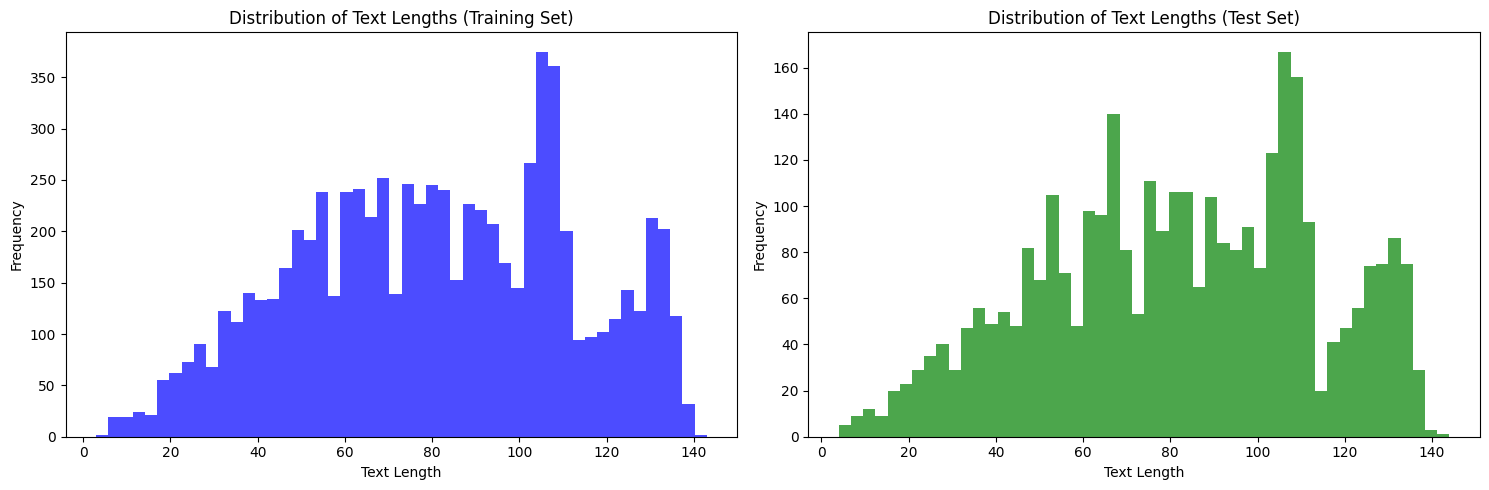

In [23]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(df_train['length'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Text Lengths (Training Set)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df_test['length'], bins=50, color='green', alpha=0.7)
plt.title('Distribution of Text Lengths (Test Set)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

It seems most tweets are around 140 characters, which was the former character limit for Twitter, so this data checks out and seems sensible.

Next, we will convert the text to embeddings. Embedding are defined by Cloudflare [5] as vector representations of values or objects like text, images, and audio that are designed to be consumed by machine learning models and semantic search algorithms, embedding allow you to perform mathematical analysis on otherwise non-mathematical objects such as text or images.

Tf-idf will be used for this. Wikipedia [4] defines tf-idf as a measure of importance of a word to a document in a collection or corpus, adjusted for the fact that some words appear more frequently in general. It is a combination of Term frequency, tf(t,d), which is the relative frequency of term t within document d, and the inverse document frequency is a measure of how much information the word provides, i.e., how common or rare it is across all documents.

We will start by vectoring the cleaned text and get feature names using the sklearn tf-idf library.

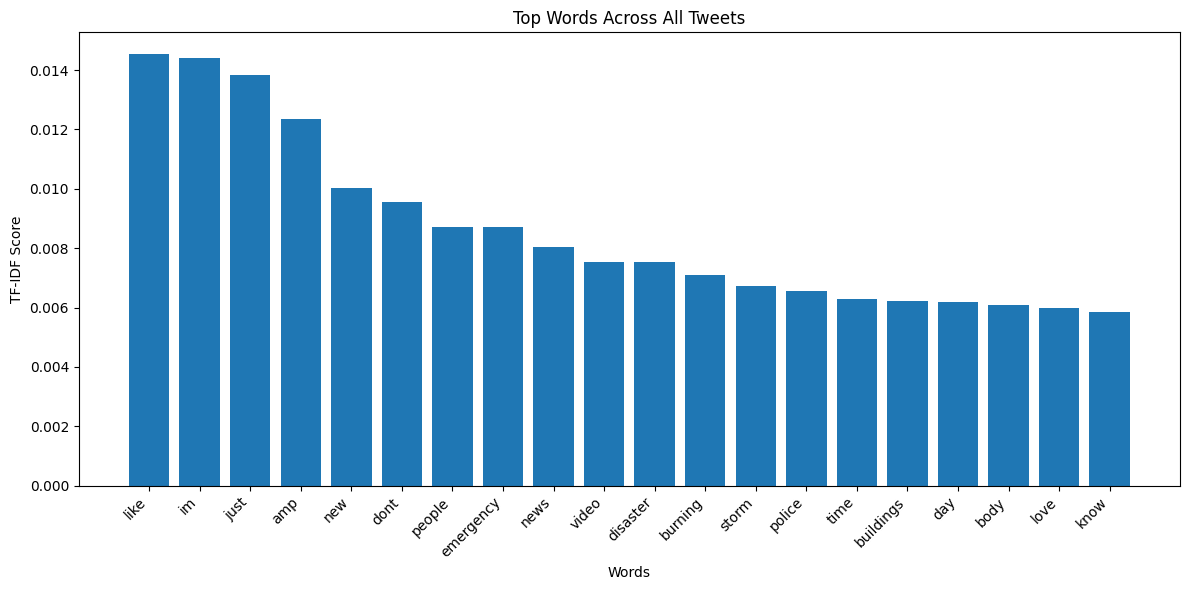

In [27]:
def get_top_words_overall(n=10):
    mean_scores = []
    for word_index in range(len(feature_names)):
        word_scores = text_vectors[:, word_index].toarray().flatten()
        mean_score = sum(word_scores) / len(word_scores)
        mean_scores.append(mean_score)
    word_score_pairs = list(zip(feature_names, mean_scores))
    sorted_pairs = sorted(word_score_pairs, key=lambda x: x[1], reverse=True)
    top_words = sorted_pairs[:n]
    return top_words
top_words = get_top_words_overall(n=20)
words, scores = zip(*top_words)

plt.figure(figsize=(12, 6))
plt.bar(words, scores)
plt.title('Top Words Across All Tweets')
plt.xlabel('Words')
plt.ylabel('TF-IDF Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

We can try creating a word cloud of the tweet text to get an alternate type of visualization.

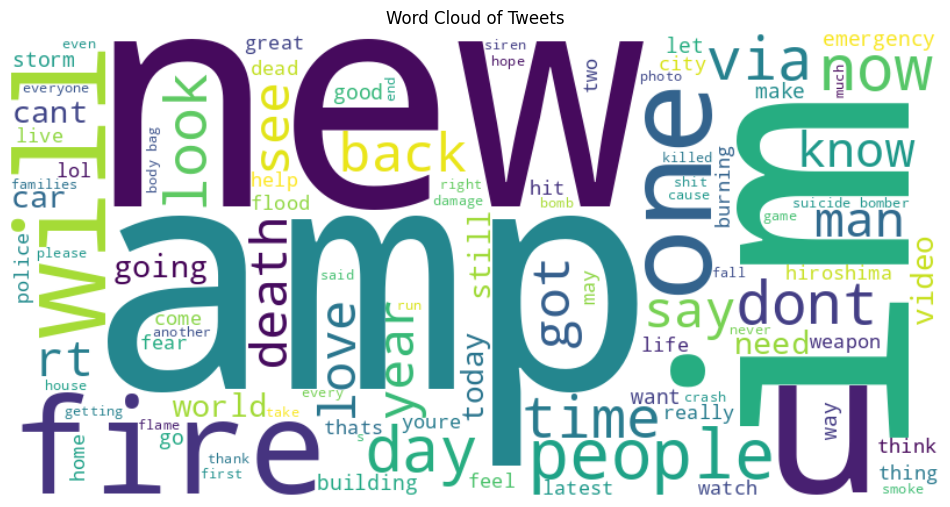

In [28]:
text_data = ' '.join(df_train['clean_text'])

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100
).generate(text_data)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweets')
plt.show()

Now that we have a good view of which words are the most popular let us use the "target" field which uses 0s and 1s to indicate whether a tweet refers to a real disaster. We can use binary classification to create a graph mapping out the distribution of how many disasters vs non-disasters are in the dataset.

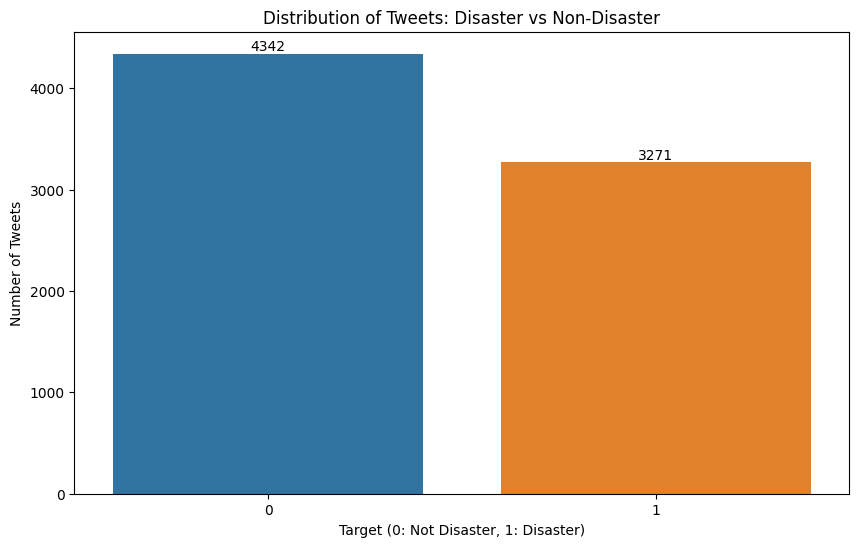

In [29]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='target', data=df_train)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Distribution of Tweets: Disaster vs Non-Disaster')
plt.xlabel('Target (0: Not Disaster, 1: Disaster)')
plt.ylabel('Number of Tweets')
plt.show()

It appears that most tweets in the dataset are not disasters, but it is not a huge majority. Next, we can pre-process the data before we start creating models.

In [30]:
X = df_train["clean_text"]
y = df_train["target"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = df_test["clean_text"]

For our choice of RNN models we will try both LSTM and GRU models since both can in theory fit this type of data. LTSM is good at handling vanishing gradient problems and is very popular for short text classification of this type. GRU meanwhile is simpler than LTSM but offers comparable performance, which means it is more efficient and might suit the short text length of a tweet better.

To utilize these methods we will first pre-process the text data through tokenization and padding. We then define the model, compile and train it, and finally plot the results.

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.6222 - loss: 0.6494 - val_accuracy: 0.7984 - val_loss: 0.4556
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8289 - loss: 0.3947 - val_accuracy: 0.8004 - val_loss: 0.4470
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8791 - loss: 0.3013 - val_accuracy: 0.7827 - val_loss: 0.4767
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9053 - loss: 0.2431 - val_accuracy: 0.7958 - val_loss: 0.4988
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9189 - loss: 0.2186 - val_accuracy: 0.7649 - val_loss: 0.5292
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9043 - loss: 0.2635 - val_accuracy: 0.7663 - val_loss: 0.5655
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9263 - loss: 0.1965 - val_accuracy: 0.7708 - val_loss: 0.5873
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9379 - loss: 0.1711 - val_accuracy: 0.757

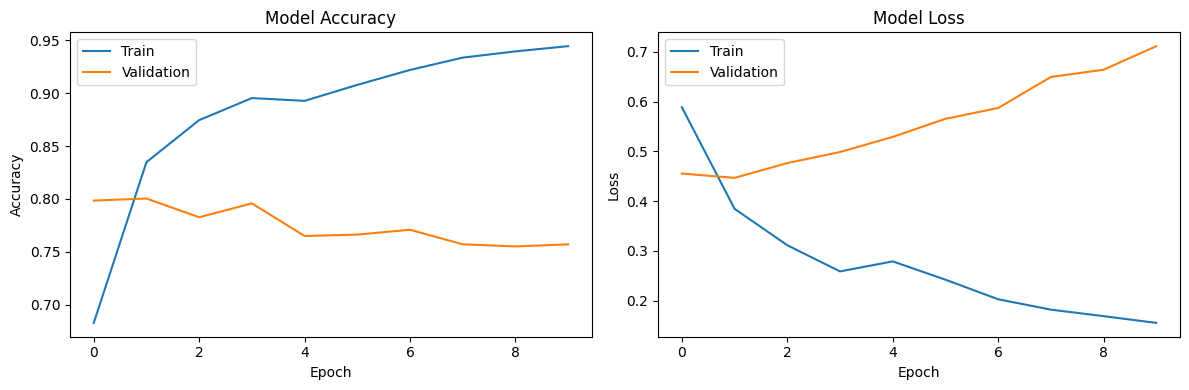

In [31]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=50)
X_val_pad = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=50)
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=50)

model = models.Sequential([
    layers.Embedding(5000, 32, input_length=50),
    layers.Dropout(0.3),
    layers.LSTM(32),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

history = model.fit(X_train_pad, y_train,
                   validation_data=(X_val_pad, y_val),
                   epochs=10,
                   batch_size=32)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

This result shows clear signs of overfitting since the gap between the training and validation data is so huge. We will try simplifying the model by reducing the amount of embedding dimensions and LSTM layers, we will also reduce the amount of epochs run.

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.5734 - loss: 0.6789 - val_accuracy: 0.7387 - val_loss: 0.6055
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7600 - loss: 0.5464 - val_accuracy: 0.7945 - val_loss: 0.4795
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8303 - loss: 0.4154 - val_accuracy: 0.8050 - val_loss: 0.4462
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8647 - loss: 0.3518 - val_accuracy: 0.8089 - val_loss: 0.4401
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8789 - loss: 0.3061 - val_accuracy: 0.8056 - val_loss: 0.4612


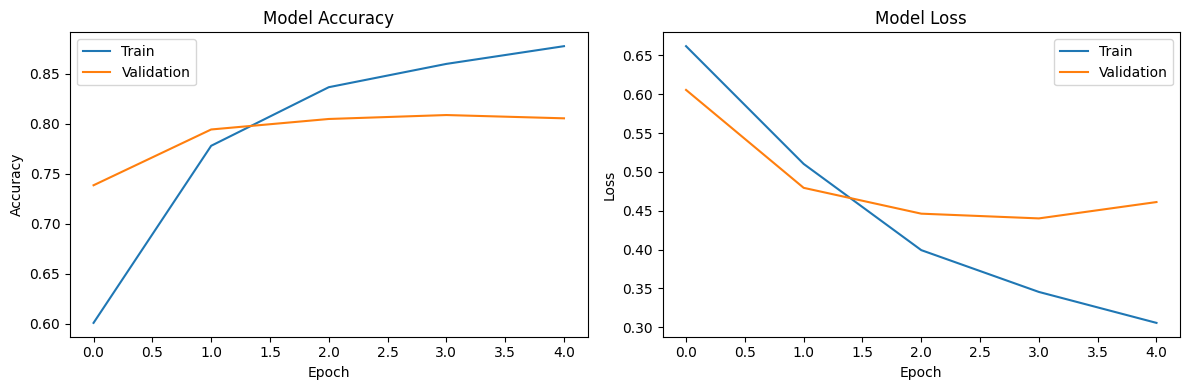

In [32]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=50)
X_val_pad = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=50)
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=50)

model = models.Sequential([
   layers.Embedding(5000, 8, input_length=50),
   layers.Dropout(0.5),
   layers.LSTM(8),
   layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

history = model.fit(X_train_pad, y_train,
                  validation_data=(X_val_pad, y_val),
                  epochs=5,
                  batch_size=32)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

This result seems a lot better and indicates that our simplification of the model reduced the amount of overfitting. The accuracy is quite high but the gap between the training and validation data isn't huge anymore. We will now create a GRU model using similar hyperparameter tuning.

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.5616 - loss: 0.6855 - val_accuracy: 0.5817 - val_loss: 0.6441
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6762 - loss: 0.5955 - val_accuracy: 0.7853 - val_loss: 0.4752
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8232 - loss: 0.4081 - val_accuracy: 0.8004 - val_loss: 0.4551
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8494 - loss: 0.3431 - val_accuracy: 0.8017 - val_loss: 0.4626
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8768 - loss: 0.3030 - val_accuracy: 0.8037 - val_loss: 0.4754


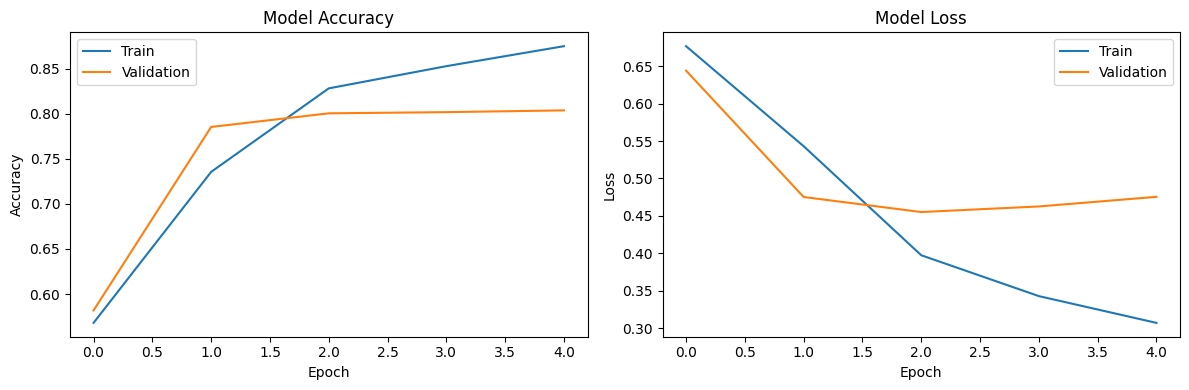

In [33]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

model = models.Sequential([
    layers.Embedding(5000, 8, input_length=50),
    layers.Dropout(0.5),
    layers.GRU(8),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

history = model.fit(X_train_pad, y_train,
                   validation_data=(X_val_pad, y_val),
                   epochs=5,
                   batch_size=32)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

The GRU model seems to perform about as good as the LSTM model, indicating that both models are suitable to this dataset given a sufficient amount of hyperparameter tuning. In particular the model wasn't simple enough at first which led to overfitting but once embedding dimensions and LSTM/GRU layers were reduced the models yielded a similar result. However GRU is known as a computationally more efficient model which means that running it would take less time, cost less CPU/GPU resources and require less energy, meaning that it is a leaner and greener solution. A potential improvement would be to use an even simpler model solution such as a Feed-Forward Neural Network which would be even simpler and faster to train.

References:

[1] https://www.kaggle.com/c/nlp-getting-started/overview

[2] https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets/notebook

[3] https://keras.io/keras_hub/getting_started/

[4] https://en.wikipedia.org/wiki/Tf–idf#Definition

[5] https://www.cloudflare.com/learning/ai/what-are-embeddings/